# Cyclic peptides

In [12]:
import pandas as pd
# df_train = pd.read_csv('data/CycPeptMPDB/train.csv')
# df_test = pd.read_csv('data/CycPeptMPDB/test.csv')
df_train = pd.read_csv('data/CycPeptMPDB/img_train.csv')
df_test = pd.read_csv('data/CycPeptMPDB/img_test.csv')

pd.set_option('display.max_colwidth', None)

# display(df_all.head()['helm'])

y_train = df_train.score.values
y_test = df_test.score.values

## Feature processing

### Fingerprints (fps)

In [3]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def fingerprints_from_smiles(smiles: List, size=2048):
    """
        Create ECFP fingerprints of smiles, with validity check
    """
    fps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        valid_mask.append(int(mol is not None))
        fp = fingerprints_from_mol(mol, size=size) if mol else np.zeros((1, size))
        fps.append(fp)

    fps = np.concatenate(fps, axis=0)
    return fps, valid_mask


def fingerprints_from_mol(molecule, radius=3, size=2048, hashed=False):
    """
        Create ECFP fingerprint of a molecule
    """
    if hashed:
        fp_bits = AllChem.GetHashedMorganFingerprint(molecule, radius, nBits=size)
    else:
        fp_bits = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=size)
    fp_np = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp_bits, fp_np)
    return fp_np.reshape(1, -1)

In [118]:
# train = True
train = False
if train:
    X_train = fingerprints_from_smiles(df_train.smi)[0]
    X_test = fingerprints_from_smiles(df_test.smi)[0]

    np.save('data/CycPeptMPDB/X_train_fps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_fps.npy', X_test)
else:
    X_train = np.load('data/CycPeptMPDB/X_train_fps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_fps.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7451, 2048), (7451,), (5960, 2048), (5960,), (1491, 2048), (1491,))

### BERT features

In [ ]:
from dataset.tokenizer import SmilesTokenizer, AATokenizer, BPETokenizer
from model.bert import BERT
from utils.utils import parse_config, load_model
import torch

def load_bert_model(ckpt, config, device='cuda', model_type='smi_bert'):
    if model_type == 'smi_bert':
        tokenizer = SmilesTokenizer(max_len=config.data.max_len)
    elif model_type == 'aa_bert':
        tokenizer = AATokenizer(max_len=config.data.max_len)
    elif config.data.type == 'bpe':
        tokenizer = BPETokenizer(bpe_path=config.data.bpe_path, max_len=config.data.max_len)
    else:
        raise ValueError(f'Invalid model_type: {model_type}')

    model = BERT(tokenizer, **config.model)
    model = load_model(model, ckpt, device)
    model.eval()
    return model, device

def get_bert_embd(encoder, inputs, device='cuda',):
    with torch.no_grad():
        tokens = encoder.tokenize_inputs(inputs).to(device)
        batch_lens = (tokens != encoder.tokenizer.pad_token_id).sum(1)
        embd = encoder.embed(tokens)
        reps = []
        for i, tokens_len in enumerate(batch_lens):
            reps.append(embd[i, 1 : tokens_len - 1].mean(0))
    return torch.stack(reps)

def encode_with_bert(list, model, device='cuda', batch_size=128):
    reps = []
    for i in range(0, len(list), batch_size):
        reps.append(get_bert_embd(model, list[i : i + batch_size], device=device))
    reps = torch.cat(reps).cpu().numpy()
    # logger.info(f"list shape: {list.shape}, reps shape: {reps.shape}")
    return reps

#### SMILES BERT

In [ ]:
# train = True
train = False
if train:
    ckpt='results/train_smi_bert/model_2_1.966.pt'  # 0.555	0.809	0.339	0.705	0.588
    config_file='configs/train_smi_bert_test.yaml'
    config = parse_config(config_file)
    model, device = load_bert_model(ckpt=ckpt, config=config)

    X_train = encode_with_bert(df_train.smi, model)
    X_test = encode_with_bert(df_test.smi, model)

    np.save('data/CycPeptMPDB/X_train_smi_bert.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_smi_bert.npy', X_test)
else:
    X_train = np.load('data/CycPeptMPDB/X_train_smi_bert.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_smi_bert.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 512), (5960,), (1491, 512), (1491,))

### RDKit descriptors

In [2]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List
from rdkit import rdBase, Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def getMolDescriptors(mol, missingVal=0):
    """ calculate the full list of descriptors for a molecule """

    values, names = [], []
    for nm, fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        values.append(val)
        names.append(nm)

    custom_descriptors = {'hydrogen-bond donors': rdMolDescriptors.CalcNumLipinskiHBD,
                          'hydrogen-bond acceptors': rdMolDescriptors.CalcNumLipinskiHBA,
                          'rotatable bonds': rdMolDescriptors.CalcNumRotatableBonds,}
    for nm, fn in custom_descriptors.items():
        try:
            val = fn(mol)
        except:
            val = missingVal
        values.append(val)
        names.append(nm)
    return values,names

# getMolDescriptors('CC(=O)SCCCC[C@H](N)C(O)=O')

#### Peptide descriptors

In [3]:
def get_pep_dps_from_smi(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
    except:
        print(f"convert smi {smi} to molecule failed!")
        mol = None
    
    dps, _ = getMolDescriptors(mol)
    return np.array(dps)

def get_pep_dps(smi_list):
    return np.array([get_pep_dps_from_smi(smi) for smi in smi_list])

In [4]:
import numpy as np

# train = True
train = False
if train:
    
    X_train = get_pep_dps(df_train.smi)
    X_test = get_pep_dps(df_test.smi)

    np.save('data/CycPeptMPDB/X_train_pep_dps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_pep_dps.npy', X_test)
else:
    X_train = np.load('data/CycPeptMPDB/X_train_pep_dps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_pep_dps.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7451, 211), (7451,), (5960, 211), (5960,), (1491, 211), (1491,))

### ResNet features

In [26]:
from utils.utils import parse_config, load_model
from model.resnet import init_model
from model.molcl import MolCL

ckpt_file='results/pretrain_resnet/model_9_0.354.pt'
config_file='configs/pretrain_resnet.yaml'
device='cuda'

config = parse_config(config_file)
resnet = init_model(**config.model.resnet)
model = MolCL(resnet, device, **config.model.molcl)

model = load_model(model, ckpt_file, device)

In [ ]:
resnet = model.encoder
from torch import nn
for r, c in zip(list(resnet.children())[:-1], list(model.encoder.children())):
    r = c

In [14]:
from torchvision import transforms
import torch
import cv2
from utils.utils import parse_config, load_model
from model.resnet import init_model
from model.molcl import MolCL

def load_molcl_model(ckpt_file='results/pretrain_resnet/model_9_0.354.pt', config_file='configs/pretrain_resnet.yaml', device='cuda'):
    config = parse_config(config_file)
    resnet = init_model(**config.model.resnet)
    model = MolCL(resnet, device, **config.model.molcl)

    model = load_model(model, ckpt_file, device)
    return model

def get_resnet_embd(model, img):
    with torch.no_grad():
        embd = model.get_img_embd(img)
    return embd

def load_transform_img(img_paths, transform):
    imgs = [transform(cv2.imread(fp)) for fp in img_paths]
    img = torch.stack(imgs)
    return img

def encode_with_molcl(list, model, device='cuda', batch_size=80, image_size=500):
    transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((image_size, image_size)), transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])
    reps = []
    model.to(device)
    for i in range(0, len(list), batch_size):
        img_paths = list[i : i + batch_size]
        img = load_transform_img(img_paths, transform)
        img = img.to(device)
        reps.append(get_resnet_embd(model, img))
    reps = torch.cat(reps).cpu().numpy()
    # logger.info(f"list shape: {list.shape}, reps shape: {reps.shape}")
    return reps

# encode_with_resnet(["data/gradcam/cycpep_0.png"], model)

In [16]:
import numpy as np

train = True
# train = False
if train:
    model = load_molcl_model()
    X_train = encode_with_molcl(df_train.smi_img, model)
    X_test = encode_with_molcl(df_test.smi_img, model)

    np.save('data/CycPeptMPDB/X_train_molimg_embd.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_molimg_embd.npy', X_test)
else:
    X_train = np.load('data/CycPeptMPDB/X_train_molimg_embd.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_molimg_embd.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 2048), (5960,), (1491, 2048), (1491,))

## Modeling

### Final features

In [23]:
# features = ['pep_dps', ]
# features = ['fps', ]
# features = ['smi_bert', ]
features = ['molimg_embd', ]

# features = ['pep_dps', 'fps', ]
# features = ['pep_dps', 'smi_bert', ]
# features = ['fps', 'smi_bert', ]

# features = ['fps', 'pep_dps', 'smi_bert', ]
# features = ['fps', 'pep_dps', 'molimg_embd', ]

X_train_features = []
X_test_features = []
for feat in features:
    try:
        X_train = np.load(f'data/CycPeptMPDB/X_train_{feat}.npy')
        X_test = np.load(f'data/CycPeptMPDB/X_test_{feat}.npy')

        X_train_features.append(X_train)
        X_test_features.append(X_test)
    except:
        raise ValueError(f'Feature {feat} not supported')

X_train = np.concatenate(X_train_features, axis=1)
X_test = np.concatenate(X_test_features, axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 2048), (5960,), (1491, 2048), (1491,))

In [24]:
import matplotlib.pyplot as plt
from utils.utils import get_regresssion_metrics

def plot_scatter_y(y, y_hat, x_label='y', y_label='y_hat', save_path=None):
    plt.scatter(y, y_hat, alpha=0.1)
    get_regresssion_metrics(y, y_hat)
    mae = np.mean(np.abs(y - y_hat))
    print(f'MAE: {mae:.3f}, y mean: {np.mean(y):.3f}, y_hat mean: {np.mean(y_hat):.3f}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if save_path:
        plt.savefig(save_path+f'_{mae:.3f}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

### XGBoost regressor

MAE 	 MSE 	 R2 	 Spearman 	 Pearson
0.584	0.860	-1.287	0.645	0.546
MAE: 0.584, y mean: -5.876, y_hat mean: -5.851


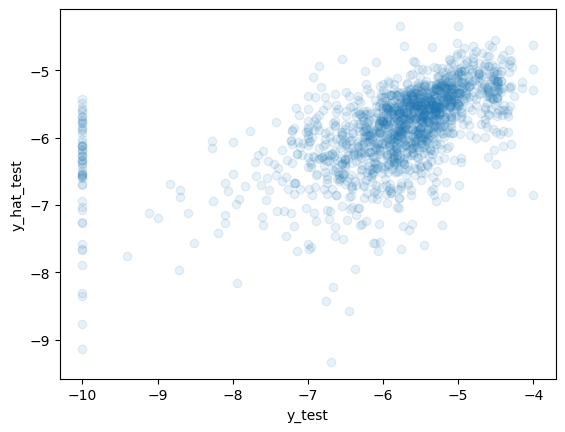

In [25]:
from xgboost import XGBRegressor
import joblib

is_save = False
save_path='data/CycPeptMPDB/fps_xgbr.model'

model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)
if is_save:
    joblib.dump(model, save_path)
    model = joblib.load(save_path)
y_hat = model.predict(X_test)
plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path=save_path)